#Разведочный анализ данных (NLP)

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import re
import string
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import nltk
import spacy
from nltk import FreqDist
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from string import punctuation
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import random
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Загрузим датафрейм с книгами топ100 авторов

In [ ]:
top100 = pd.read_parquet('//content//drive//MyDrive//books_//top100.pq')

Оставим по одной, первой книге для каждого автора, получим датафрейм b101

In [ ]:
b101 = top100.drop_duplicates(subset='author', keep='first')

Посмотрим, какие признаки содержит данный датафрейм

In [ ]:
b101.columns

Index(['author', 'author_sn', 'title', 'text_', 'FileName', 'is_gutenberg',
       'text_len', 'text_len2', 'words_cnt', 'words_symbols', 'words_dots',
       'words_commas', 'words_excls', 'words_questions', 'words_semicolons',
       'words_colons', 'words_dashs', 'words_aposts', 'words_ellipsis',
       'words_quots', 'median_word_length', 'max_word_length',
       'mean_word_length', 'cnt_adv_freq', 'cnt_swadesh_freq', 'uniq_word_cnt',
       'cnt_words_unique', 'unwords_words', 'cnt_word_eng', 'prc_wrds_not_eng',
       'a_books_cnt', 'cnt_sent', 'wrds_sent_cnt', 'pos_distr', 'entities',
       'len_ent', 'uchars_cnt', 'uchars_frq'],
      dtype='object')

## Описание признаков
1.  'author' - имя и фамилия автора (данные для целевой переменной)
2.  'author_sn' - фамилия автора
3.  'title' - название книги
4.  'text_' - текст книги без пробельных символов и метаданных
5.  'FileName' - имя файла с текстом данной книги
6.  'is_gutenberg' - спарсена ли книга с сайта gutenberg
7.  'text_len' - количество символов в оригинальном тексте, до обработки
8.  'text_len2' - количество символов в "text_"
9.  'words_cnt' - количество слов
10. 'words_symbols' - отношение количества слов к количеству символов
11. 'words_dots' - отношение количества слов к количеству точек
12. 'words_commas' - отношение количества слов к количеству запятых
13. 'words_excls' - отношение количества слов к количеству восклицательных знаков
14. 'words_questions' - отношение количества слов к количеству вопросительных знаков
15. 'words_semicolons' - отношение количества слов к количеству точек с запятой
16. 'words_colons' - отношение количества слов к количеству двоеточий
17. 'words_dashs' - отношение количества слов к количеству тире
18. 'words_aposts' - отношение количества слов к количеству апострофов
19. 'words_ellipsis' - отношение количества слов к количеству многоточий
20. 'words_quots' - отношение количества слов к количеству кавычек
21. 'median_word_length' - медианная длина слов
22. 'max_word_length' - максимальная длина слова
23. 'mean_word_length' - средняя длина слова
24. 'cnt_adv_freq' - словарь с количествами частотных наречий
25. 'cnt_swadesh_freq' - словарь с количествами слов из списка Сводеша
26. 'uniq_word_cnt' - словарь с количествами уникальных слов
27. 'cnt_words_unique' - количество уникальных слов
28. 'unwords_words' - отношение количества уникальных слов к количеству слов
29. 'cnt_word_eng' - количество уникальных слов из словаря англ. языка
30. 'prc_wrds_not_eng' - отношение количества английских слов к количеству слов
31. 'a_books_cnt' - количество книг автора
32. 'cnt_sent' - количество предложений
33. 'wrds_sent_cnt' - отношение количества слов к количеству предложений, или средняя длина предложения
34. 'pos_distr' - словарь с количествами слов по частям речи для первых 33332 сиволов
35. 'entities' - именованные сущности для первых 33332 сиволов
36. 'len_ent' - количество уникальных ИС для первых 33332 сиволов
37. 'unq_ent_frq' - словарь с количествами уникальных ИС для первых 33332 сиволов
38. 'uchars_cnt' - количество уникальных сиволов
39. 'uchars_frq' - словарь с количествами уникальных сиволов






Посмотри на размер датафрейма

In [ ]:
b101.shape

(101, 38)

Посмотрим на типы данных признаков

In [ ]:
b101.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   author              101 non-null    object 
 1   author_sn           101 non-null    object 
 2   title               101 non-null    object 
 3   text_               101 non-null    object 
 4   FileName            101 non-null    object 
 5   is_gutenberg        101 non-null    int64  
 6   text_len            101 non-null    int64  
 7   text_len2           101 non-null    int64  
 8   words_cnt           101 non-null    int64  
 9   words_symbols       101 non-null    float64
 10  words_dots          101 non-null    float64
 11  words_commas        101 non-null    float64
 12  words_excls         101 non-null    float64
 13  words_questions     101 non-null    float64
 14  words_semicolons    101 non-null    float64
 15  words_colons        101 non-null    float64
 16  words_da

Посомтрим описательные статистики признаков с типом object

In [ ]:
b101.describe(include='object')

author author_sn           title  \
count               101       101             101   
unique              101       101              94   
top     Alexandre_Dumas     Dumas  Selected_Poems   
freq                  1         1               5   

                                                    text_  \
count                                                 101   
unique                                                101   
top     CELEBRATED CRIMES, COMPLETE BY ALEXANDRE DUMAS...   
freq                                                    1   

                                              FileName  \
count                                              101   
unique                                             101   
top     Alexandre_Dumas-Celebrated_Crimes_Complete.txt   
freq                                                 1   

                                             cnt_adv_freq  \
count                                                 101   
unique                                                101   
top     {'always': 265, 'never': 536, 'normally': 0, '...   
freq                                                    1   

                                         cnt_swadesh_freq  \
count                                                 101   
unique                                                101   
top     {'all': 2404, 'and': 19145, 'animal': 6, 'ash'...   
freq                                                    1   

                                            uniq_word_cnt  \
count                                                 101   
unique                                                101   
top     {'0': None, '00': 3.0, '000': 91.0, '0000258':...   
freq                                                    1   

                                                pos_distr  \
count                                                 101   
unique                                                101   
top     {'ADJ': 372, 'ADP': 809, 'ADV': 264, 'AUX': 36...   
freq                                                    1   

                                                 entities  \
count                                                 101   
unique                                                101   
top     [[ALEXANDRE, PERSON], [DUMAS, GPE], [EIGHT, DA...   
freq                                                    1   

                                               uchars_frq  
count                                                 101  
unique                                                101  
top     {' ': 622960, '!': 1474.0, '"': 10816.0, '#': ...  
freq                                                    1

Посомтрим описательные статистики числовых признаков

In [ ]:
b101.describe()

is_gutenberg      text_len     text_len2      words_cnt  words_symbols  \
count    101.000000  1.010000e+02  1.010000e+02     101.000000     101.000000   
mean       0.118812  7.449163e+05  7.344196e+05  131936.782178       0.180695   
std        0.325181  7.229571e+05  7.115687e+05  126902.038211       0.005589   
min        0.000000  1.097500e+04  1.089200e+04    2036.000000       0.163595   
25%        0.000000  2.319310e+05  2.155410e+05   39152.000000       0.177284   
50%        0.000000  5.359310e+05  5.239770e+05   99616.000000       0.180722   
75%        0.000000  1.000732e+06  9.906350e+05  182989.000000       0.184719   
max        1.000000  3.534563e+06  3.512831e+06  622961.000000       0.194039   

       words_dots  words_commas   words_excls  words_questions  \
count  101.000000    101.000000    101.000000       101.000000   
mean    20.586590     13.567753    841.894129              inf   
std      9.738782      3.213964   3031.920036              NaN   
min      8.954529      8.006705     35.043236        33.284615   
25%     13.899371     11.489609    119.991511       115.206311   
50%     18.088960     13.098039    203.370690       185.567164   
75%     23.994986     15.807868    509.887850       276.250000   
max     56.228775     24.008547  28920.333333              inf   

       words_semicolons  ...  mean_word_length  cnt_words_unique  \
count        101.000000  ...        101.000000        101.000000   
mean                inf  ...          4.539208      17240.178218   
std                 NaN  ...          0.172781      11716.950287   
min           48.571429  ...          4.150000        874.000000   
25%          118.743215  ...          4.410000       8578.000000   
50%          169.553398  ...          4.530000      14736.000000   
75%          428.248120  ...          4.640000      23069.000000   
max                 inf  ...          5.110000      53213.000000   

       unwords_words  cnt_word_eng  prc_wrds_not_eng  a_books_cnt  \
count     101.000000    101.000000        101.000000   101.000000   
mean        0.188118   4949.980198          0.320011     4.059406   
std         0.095706   2735.852993          0.062285     6.657059   
min         0.073762    441.000000          0.170117     1.000000   
25%         0.123404   2932.000000          0.283812     1.000000   
50%         0.162656   4845.000000          0.318239     1.000000   
75%         0.209088   6788.000000          0.356849     3.000000   
max         0.553614  13564.000000          0.504577    42.000000   

           cnt_sent  wrds_sent_cnt     len_ent  uchars_cnt  
count    101.000000     101.000000  101.000000  101.000000  
mean    7005.128713      20.569989  156.000000   81.237624  
std     6549.102715       9.726185   75.727538   10.494902  
min      121.000000       8.953992   41.000000   60.000000  
25%     2502.000000      13.855799  106.000000   76.000000  
50%     5042.000000      18.086638  145.000000   80.000000  
75%     8883.000000      23.991340  204.000000   87.000000  
max    30660.000000      56.208117  485.000000  111.000000  

[8 rows x 27 columns]

Создадим признак cnt_punct_frq содержащий словарь с количествами знаков препинания

In [ ]:
def punct_frq(text):
    count_punct = re.findall(r'[^\w\s]', text)
    return Counter(count_punct)

In [ ]:
b101['cnt_punct_frq'] = b101['text_'].apply(punct_frq)

Удалим всю пунутуацию из текстов

In [ ]:
def del_punct(text):
    for s in punctuation:
        text = text.replace(s, '')
    return text

In [ ]:
b101['text'] = b101['text_'].apply(lambda x: del_punct(x))

Добавим стобец с полученным, после удаления знаков пунктуации, количествами символов в книгах

In [ ]:
b101['text_len_p'] = b101['text'].apply(lambda x: len(x))

Посмотрим как изменилось данное количество на примере первой книги

In [ ]:
b101['text_len_p'].iloc[0] / b101['text_len2'].iloc[0]

0.9699262503661576

Удалим цифры

In [ ]:
def remove_digits(text):
    return re.sub(r'\d+', '', text)

b101['text'] = b101['text'].apply(remove_digits)

Добавим стобец с полученным, после удаления цифр, количествами символов в книгах

In [ ]:
b101['text_len_pd'] = b101['text'].apply(lambda x: len(x))

Посмотрим как изменилось данное количество на примере первой книги

In [ ]:
b101['text_len_pd'].iloc[0] / b101['text_len_p'].iloc[0]

0.9989023203011751

Посмотрим на распределение длин текстов в символах

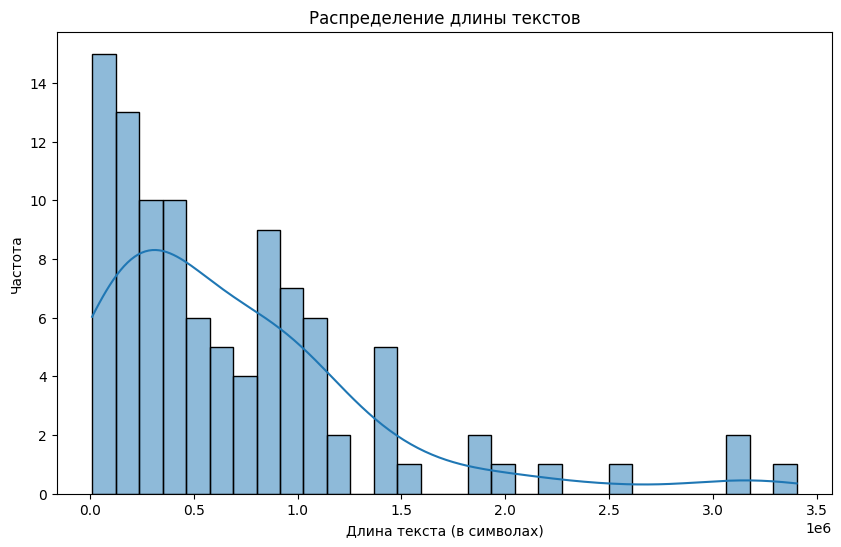

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(b101['text_len_pd'], bins=30, kde=True)
plt.title('Распределение длины текстов')
plt.xlabel('Длина текста (в символах)')
plt.ylabel('Частота')
plt.show()

Построим диаграмму размаха для длин текстов в символах

<Axes: ylabel='text_len_pd'>

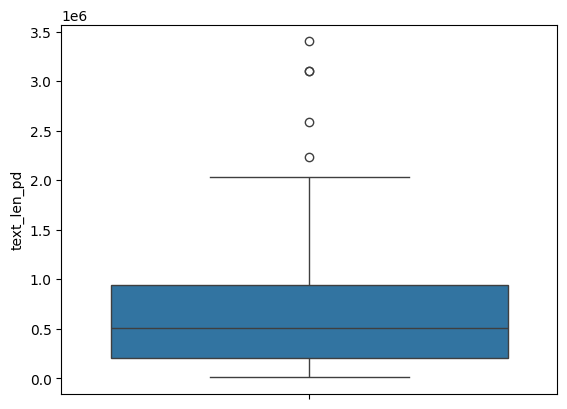

In [ ]:
sns.boxplot(data=b101.text_len_pd)

Сократим длины текстов до 500000 символов, убирая лишние символы из середины, так как, возможно, авторы больше внимание уделяют вступлению и концовке произведений.


In [ ]:
b101['text'] = b101['text'].apply(lambda x: x.replace('  ', ' '))

In [ ]:
def truncate_middle(text, total_length):
    if len(text) <= total_length:
        return text

    num_chrs = (total_length - 3) // 2
    start = text[:num_chrs]
    end = text[-num_chrs:]
    result = f"{start} {end}"
    return f"{start}{end}"

In [ ]:
txt_len = 500000
b101['txt'] = b101['text'].apply(lambda x: truncate_middle(x, txt_len))

In [ ]:
b101['txt_len'] = b101['txt'].apply(lambda x: len(x))

Посмотрим на распределение длин полученных текстов в символах

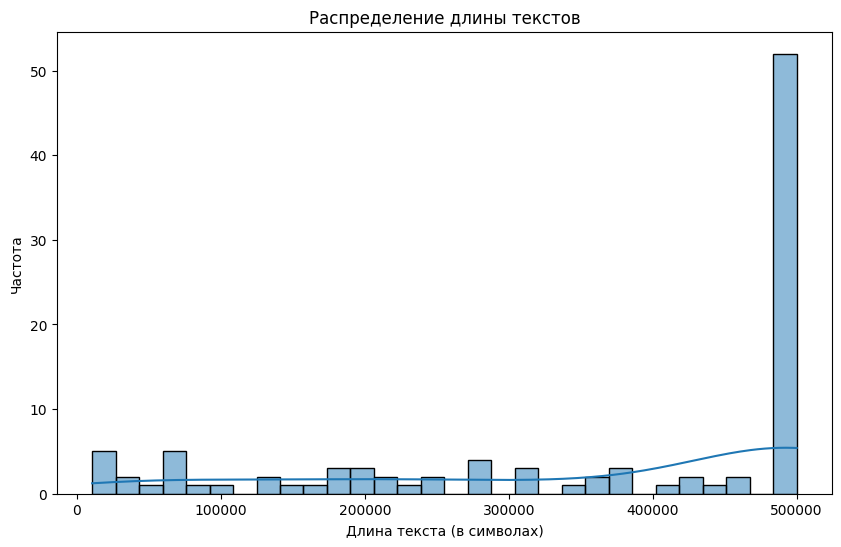

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(b101['txt_len'], bins=30, kde=True)
plt.title('Распределение длины текстов')
plt.xlabel('Длина текста (в символах)')
plt.ylabel('Частота')
plt.show()

Построим диаграмму размаха для полученных длин текстов в символах

<Axes: ylabel='txt_len'>

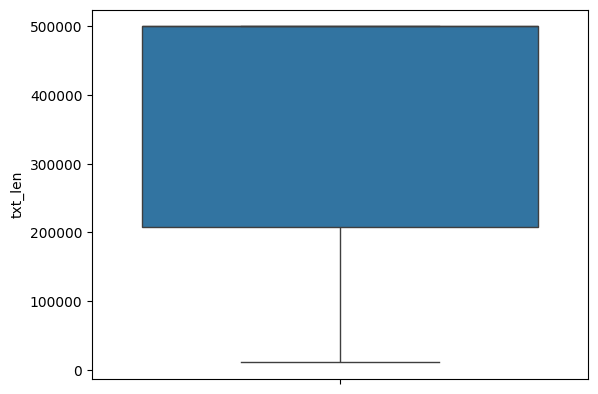

In [ ]:
sns.boxplot(data=b101.txt_len)

Посомтрим минимальную, среднюю, медианную и максимальную длины текстов

In [ ]:
b101.txt_len.min()

10549

In [ ]:
b101.txt_len.mean()

361602.41584158415

In [ ]:
b101.txt_len.median()

499996.0

In [ ]:
b101.txt_len.max()

499996

Частотный анализ слов, биграмм и триграмм

In [ ]:
def tokenize_and_clean(text):
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text.lower())
    return [word for word in tokens if word.isalpha() and word not in stop_words]

def get_top_ngrams(corpus, n=1, top_k=10):
    all_ngrams = []
    for text in corpus:
        tokens = tokenize_and_clean(text)
        n_grams = list(ngrams(tokens, n))
        all_ngrams.extend(n_grams)

    ngram_freq = Counter(all_ngrams)
    return ngram_freq.most_common(top_k)

In [ ]:
top_unigrams = get_top_ngrams(b101['txt'], n=1, top_k=10)
top_bigrams = get_top_ngrams(b101['txt'], n=2, top_k=10)
top_trigrams = get_top_ngrams(b101['txt'], n=3, top_k=10)

In [ ]:
def plot_top_ngrams_seaborn(ngrams, title):
    ngrams_df = pd.DataFrame(ngrams, columns=['ngram', 'count'])
    ngrams_df['ngram'] = ngrams_df['ngram'].apply(lambda x: ' '.join(x))

    plt.figure(figsize=(12, 6))
    sns.barplot(data=ngrams_df, x='ngram', y='count')
    plt.title(title)
    plt.xlabel('N-грамма')
    plt.ylabel('Частота')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [252]:
top_trigrams[:5]

[(('let', 'us', 'go'), 103),
 (('horned', 'mother', 'deer'), 98),
 (('gargantua', 'pantagruel', 'francois'), 80),
 (('pantagruel', 'francois', 'rabelais'), 80),
 (('herr', 'von', 'knobelsdorff'), 78)]

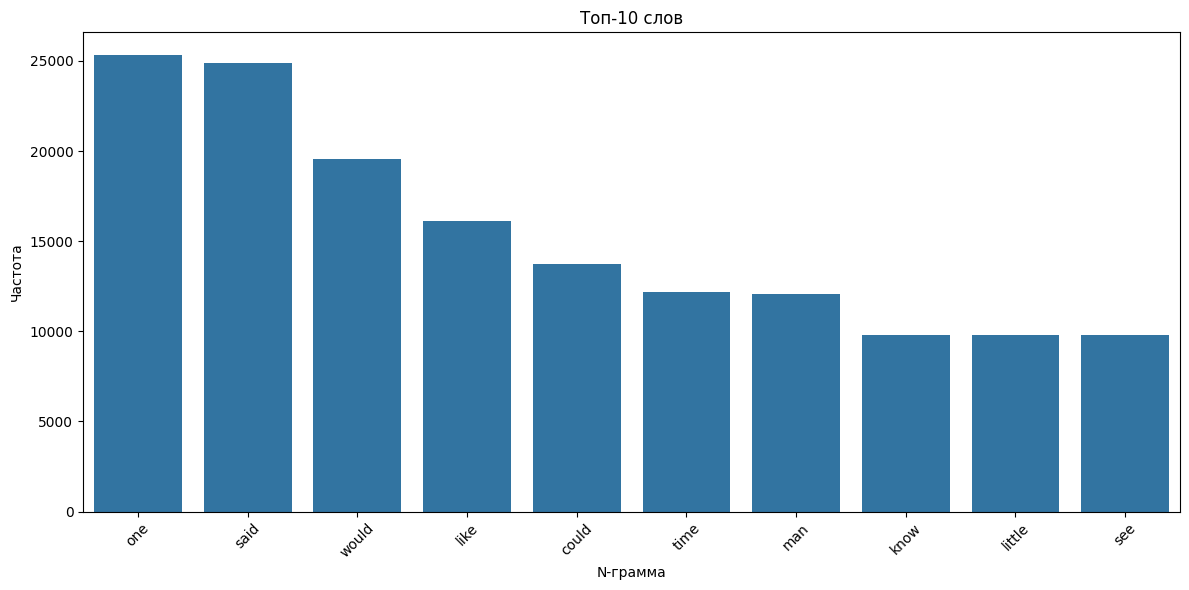

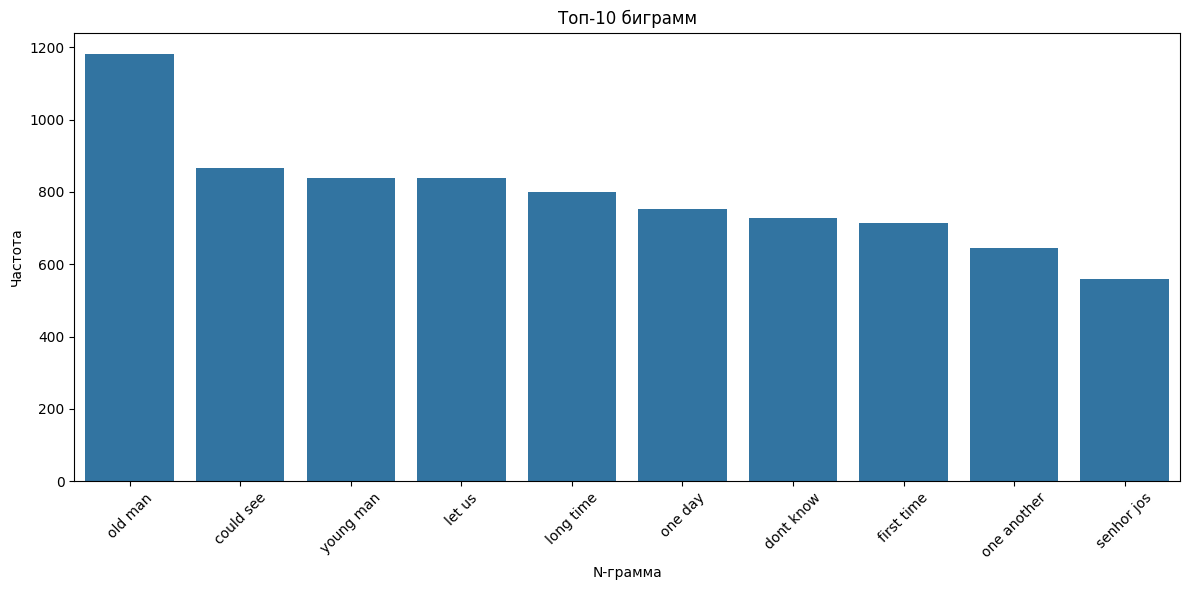

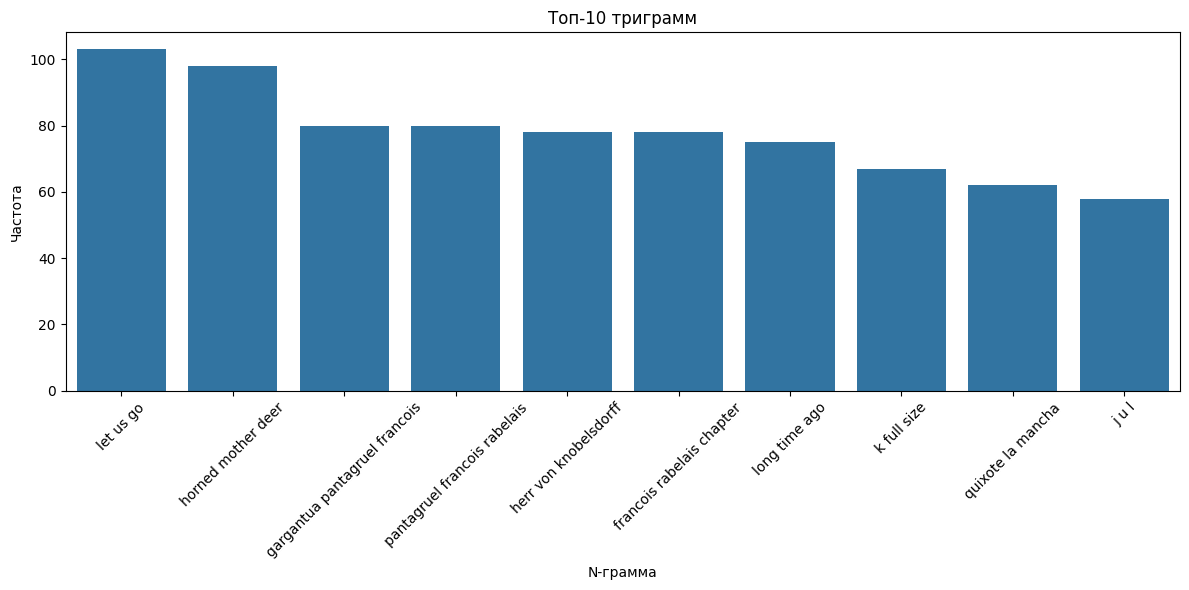

In [ ]:
plot_top_ngrams_seaborn(top_unigrams, 'Топ-10 слов')
plot_top_ngrams_seaborn(top_bigrams, 'Топ-10 биграмм')
plot_top_ngrams_seaborn(top_trigrams, 'Топ-10 триграмм')

Статистики по символам и словам

In [ ]:
nlp = spacy.load('en_core_web_sm')

def get_text_statistics(corpus):
    num_chars = [len(text) for text in corpus]
    num_words = [len(text.split()) for text in corpus]
    return num_chars, num_words

num_chars, num_words = get_text_statistics(b101['txt'])

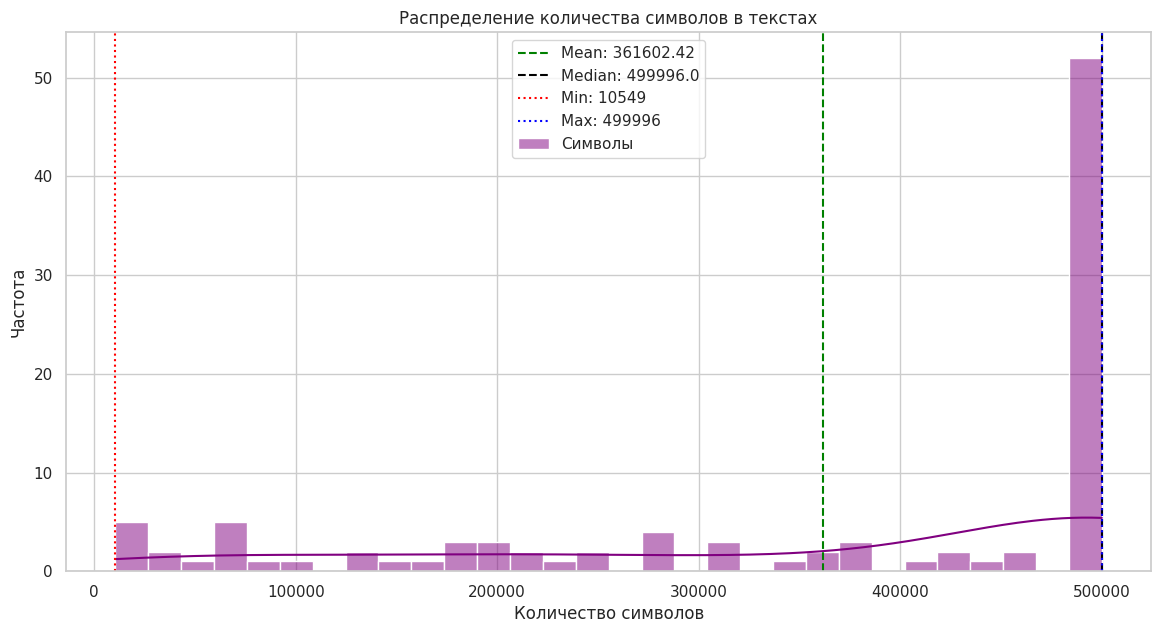

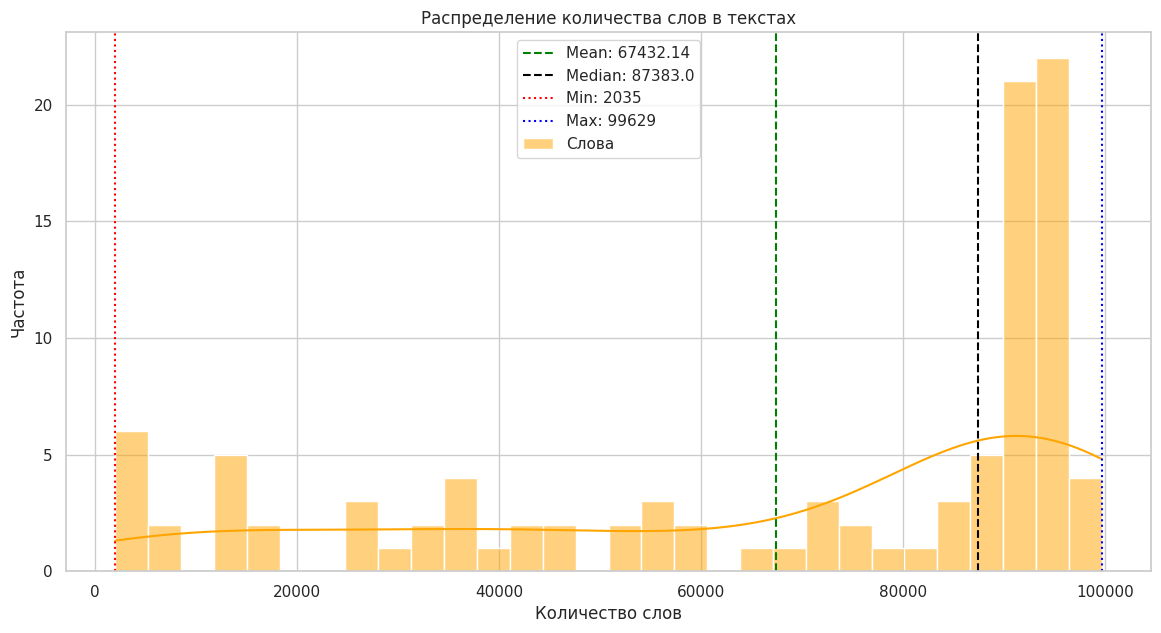

In [ ]:
mean_length = np.mean(num_chars)
median_length = np.median(num_chars)
min_length = np.min(num_chars)
max_length = np.max(num_chars)

sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))
sns.histplot(num_chars, bins=30, kde=True, color='purple', label='Символы')
plt.axvline(mean_length, color='green', linestyle='--', label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='black', linestyle='--', label=f'Median: {median_length}')
plt.axvline(min_length, color='red', linestyle=':', label=f'Min: {min_length}')
plt.axvline(max_length, color='blue', linestyle=':', label=f'Max: {max_length}')
plt.title('Распределение количества символов в текстах')
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.legend()
plt.show()

mean_length = np.mean(num_words)
median_length = np.median(num_words)
min_length = np.min(num_words)
max_length = np.max(num_words)

sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))
sns.histplot(num_words, bins=30, kde=True, color='orange', label='Слова')
plt.axvline(mean_length, color='green', linestyle='--', label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='black', linestyle='--', label=f'Median: {median_length}')
plt.axvline(min_length, color='red', linestyle=':', label=f'Min: {min_length}')
plt.axvline(max_length, color='blue', linestyle=':', label=f'Max: {max_length}')
plt.title('Распределение количества слов в текстах')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.legend()
plt.show()

In [ ]:
Q1 = np.quantile(num_words, 0.25)
Q3 = np.quantile(num_words, 0.75)
IQR = Q3 - Q1

print("(Q1):", Q1)
print("(Q3):", Q3)
print("Интерквартильный размах, для количества слов (IQR):", IQR)

(Q1): 39149.0
(Q3): 93173.0
Интерквартильный размах, для количества слов (IQR): 54024.0


Построим распределение частей речи

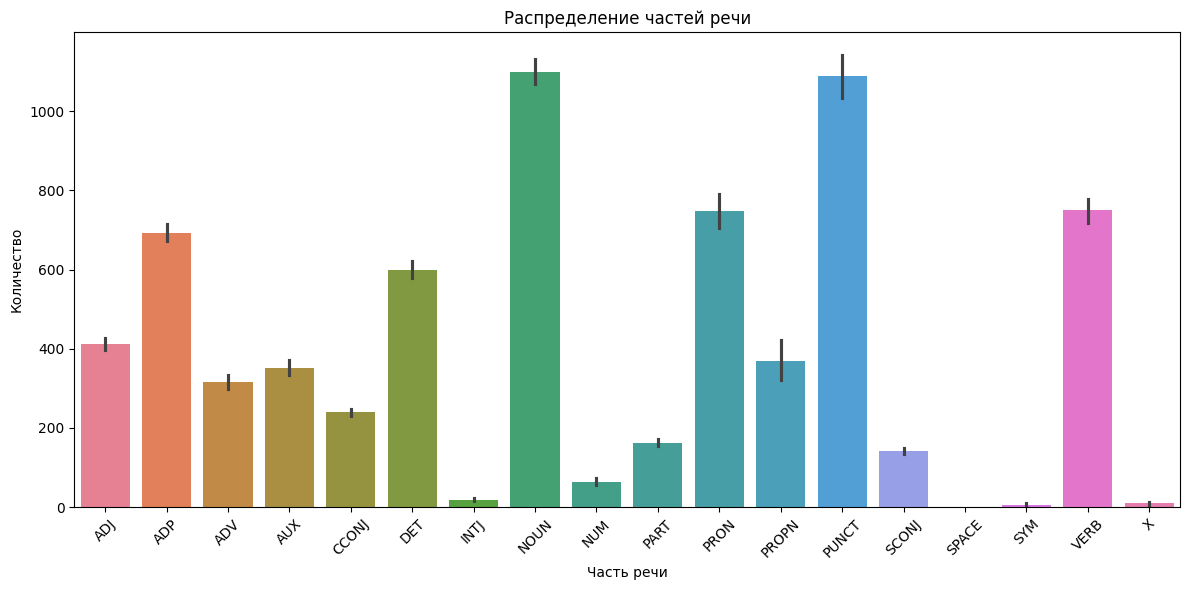

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=b101.pos_distr.apply(pd.Series))
plt.title('Распределение частей речи')
plt.xlabel('Часть речи')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
pos_df = pd.DataFrame(b101.pos_distr.apply(pd.Series)).fillna(0).astype(int)
pos_df = pd.concat([b101.author, pos_df], axis=1)
pos_df.set_index('author', inplace=True)
pos_df

ADJ  ADP  ADV  AUX  CCONJ  DET  INTJ  NOUN  NUM  \
author                                                                          
Alexandre_Dumas               372  809  264  360    206  741     5  1078  110   
Victor_Hugo                   253  650  116  215    109  668     1  1176  125   
Lev_Tolstoy                   404  554  283  323    241  468     7  1200   62   
Guy_De_Maupassant             509  881  245  234    231  719     2  1276   53   
Miguel_De_Cervantes_Saavedra  398  794  213  322    207  648     0   964   47   
...                           ...  ...  ...  ...    ...  ...   ...   ...  ...   
T_S_Eliot                     303  492  160  215    175  460    14   916  153   
Pablo_Neruda                  283  602  138  165    216  438    13  1099   19   
Jean_De_La_Fontaine           315  410  245  284    223  513    17   678   31   
Boris_Pasternak               161  411  104  112     83  243     4   733   13   
Federico_Garcia_Lorca         156  245   33   79     86  291    10   536   12   

                              PART  PRON  PROPN  PUNCT  SCONJ  SPACE  SYM  \
author                                                                      
Alexandre_Dumas                140   545    446    975    167      0    1   
Victor_Hugo                     69   395   1497   1179     57      1    0   
Lev_Tolstoy                    167   678    691    888    130      1   10   
Guy_De_Maupassant              102   477    249    911     84      0    0   
Miguel_De_Cervantes_Saavedra   123   513    964    555    105      1    1   
...                            ...   ...    ...    ...    ...    ...  ...   
T_S_Eliot                       85   451    735    963     74      0    4   
Pablo_Neruda                    63   754     27    665    162      0    0   
Jean_De_La_Fontaine            119   573    382    912    116      0    0   
Boris_Pasternak                 78   222     79    562     48      0    0   
Federico_Garcia_Lorca           48   195     82    336     34      0    0   

                              VERB   X  
author                                  
Alexandre_Dumas                667   2  
Victor_Hugo                    377  13  
Lev_Tolstoy                    696   5  
Guy_De_Maupassant              632  11  
Miguel_De_Cervantes_Saavedra   483   2  
...                            ...  ..  
T_S_Eliot                      516  25  
Pablo_Neruda                   569   0  
Jean_De_La_Fontaine            640   1  
Boris_Pasternak                379   0  
Federico_Garcia_Lorca          258   0  

[101 rows x 18 columns]

In [ ]:
pos_df.shape

(101, 18)

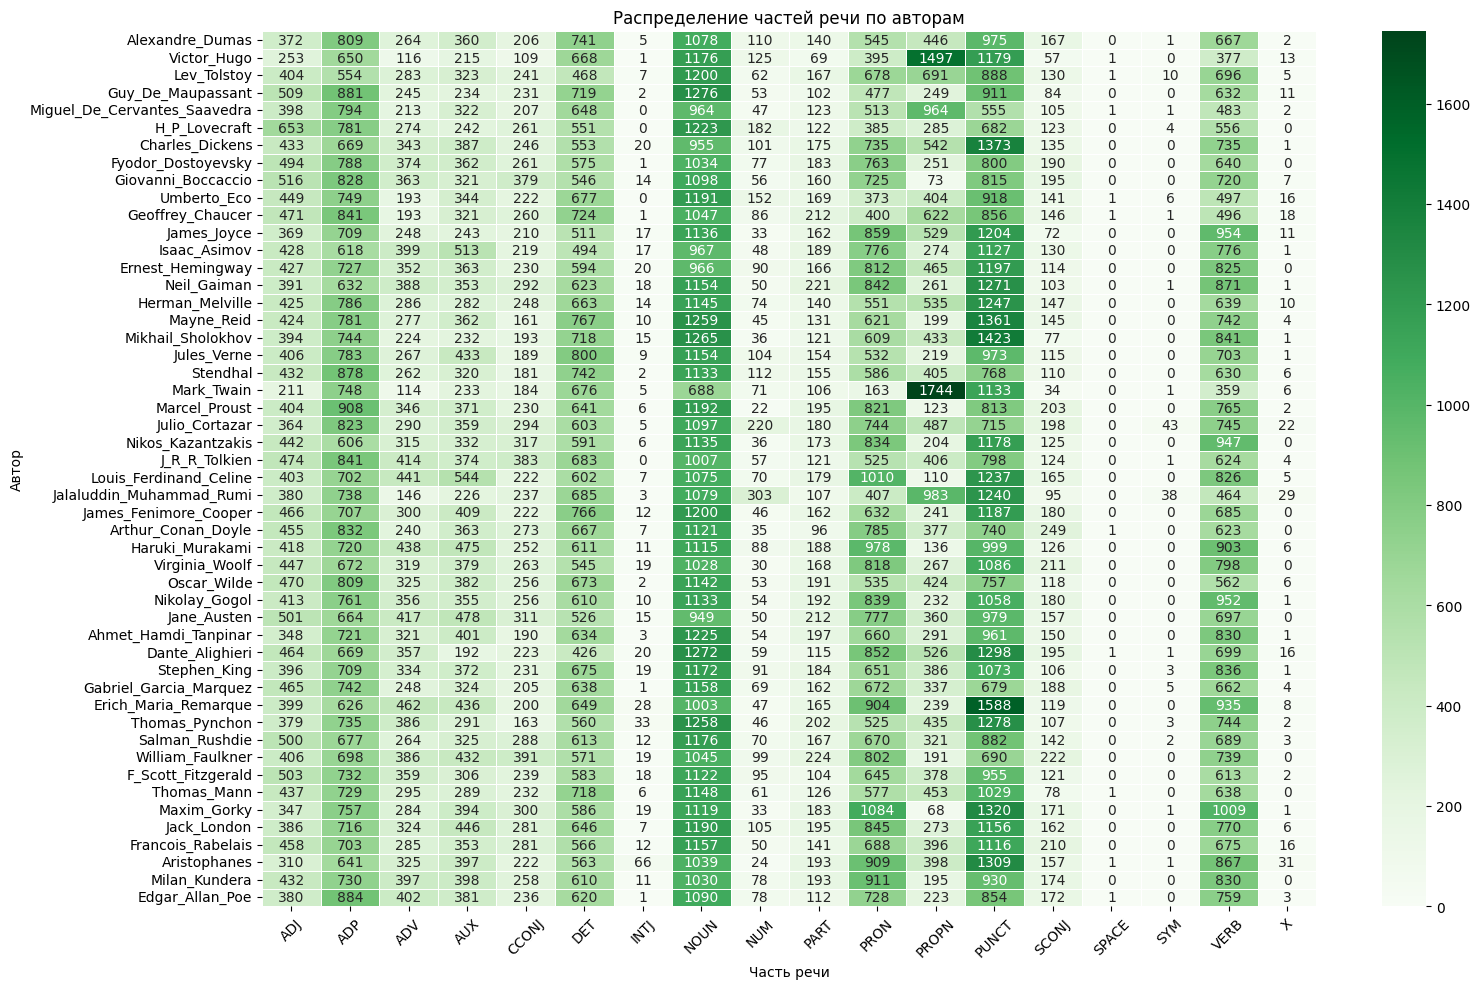

In [ ]:
plt.figure(figsize=(16, 10))
sns.heatmap(pos_df[:50], annot=True, fmt='d', cmap='Greens', linewidths=0.5)
plt.title('Распределение частей речи по авторам')
plt.xlabel('Часть речи')
plt.ylabel('Автор')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Построим распределение знаков пунктуации

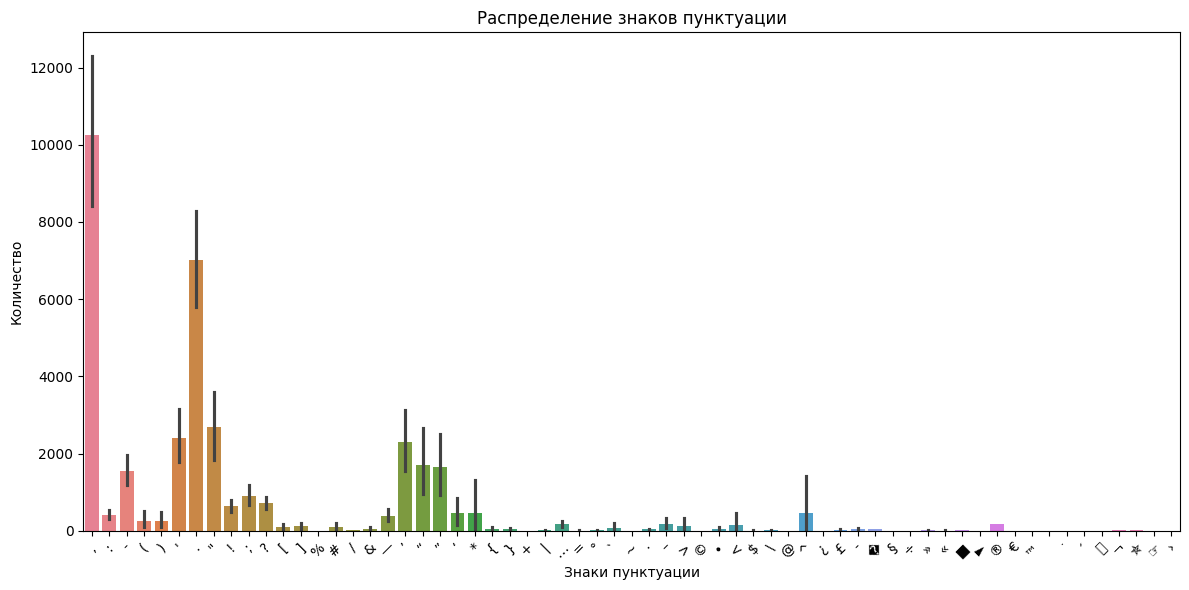

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=b101.cnt_punct_frq.apply(pd.Series))
plt.title('Распределение знаков пунктуации')
plt.xlabel('Знаки пунктуации')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
punct_df = pd.DataFrame(b101.cnt_punct_frq.apply(pd.Series)).fillna(0).astype(int)
punct_df = pd.concat([b101.author, punct_df], axis=1)
punct_df.set_index('author', inplace=True)
punct_df

,     :     -    (    )     '      .      "  \
author                                                                          
Alexandre_Dumas               53674  1777  5470  184  184  4469  20203  10816   
Victor_Hugo                   48635  2486  4626  153  153     0  30261      0   
Lev_Tolstoy                   39744   992  1759  650  650     0  30659      0   
Guy_De_Maupassant             42474  3526  5122   58   58  5132  23914  13299   
Miguel_De_Cervantes_Saavedra  36775   356  1790  556  556     0   8194      0   
...                             ...   ...   ...  ...  ...   ...    ...    ...   
T_S_Eliot                       368    33    39   20   20    86    377     99   
Pablo_Neruda                    492    21     8    1    1     0    133      0   
Jean_De_La_Fontaine             275    41   168    3    3    75    318    147   
Boris_Pasternak                 250    13    32    2    2     0    157      0   
Federico_Garcia_Lorca           150     5    12    2    2    28    120      0   

                                 !     ;  ...  €  ™  ﻿  ˙  ´    ¬  ✯  ☞  ›  
author                                    ...                                
Alexandre_Dumas               1474  5843  ...  0  0  0  0  0  0  0  0  0  0  
Victor_Hugo                   3538  5885  ...  0  0  0  0  0  0  0  0  0  0  
Lev_Tolstoy                   3925  1144  ...  0  0  0  0  0  0  0  0  0  0  
Guy_De_Maupassant             3033  2789  ...  0  0  0  0  0  0  0  0  0  0  
Miguel_De_Cervantes_Saavedra   664  6059  ...  0  0  0  0  0  0  0  0  0  0  
...                            ...   ...  ... .. .. .. .. .. .. .. .. .. ..  
T_S_Eliot                        9    26  ...  0  0  0  0  0  0  0  0  0  0  
Pablo_Neruda                     3     0  ...  0  0  0  0  0  0  0  0  0  0  
Jean_De_La_Fontaine             49    20  ...  0  0  0  0  0  0  0  0  0  0  
Boris_Pasternak                  8     0  ...  0  0  0  0  0  0  0  0  0  0  
Federico_Garcia_Lorca           20     1  ...  0  0  0  0  0  0  0  0  0  0  

[101 rows x 63 columns]

In [ ]:
punct_df.shape

(101, 63)

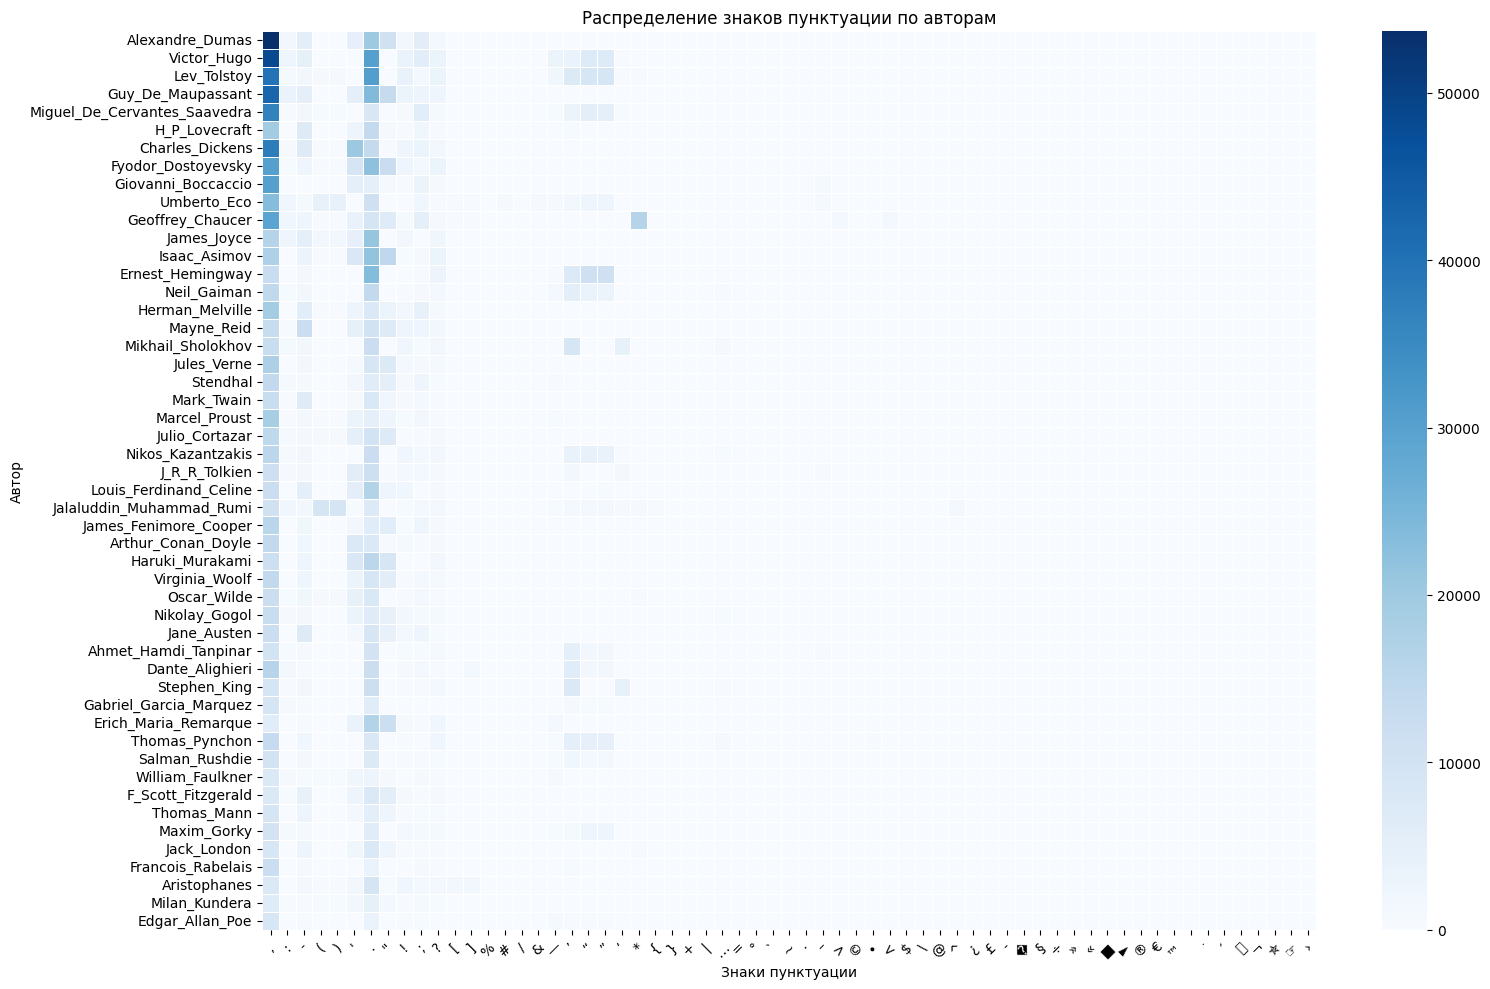

In [ ]:
plt.figure(figsize=(16, 10))
sns.heatmap(punct_df[:50], fmt='d', cmap='Blues', linewidths=0.5)
plt.title('Распределение знаков пунктуации по авторам')
plt.xlabel('Знаки пунктуации')
plt.ylabel('Автор')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Изучение связи текстовых признаков с целевой переменной

Создадим признак lex_div (lexical_diversity) - лексическое разнообразие

In [ ]:
b101['lex_div'] = b101['txt'].apply(lambda x: len(set(x.split())) / len(x.split()))

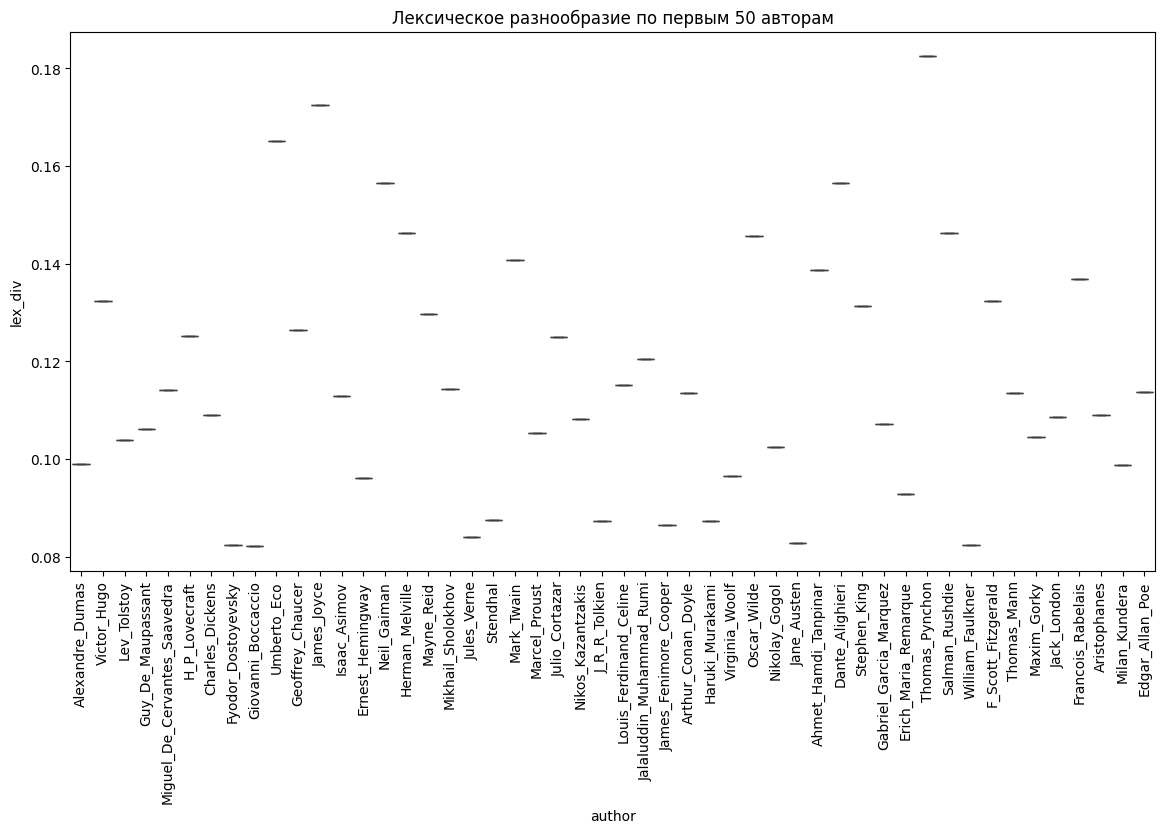

In [ ]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=b101[:50], x='author', y='lex_div')
plt.title('Лексическое разнообразие по первым 50 авторам')
plt.xticks(rotation=90)
plt.show()

TF-IDF анализ

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(b101['txt'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
b101['tfidf_keywords'] = tfidf_df.idxmax(axis=1)

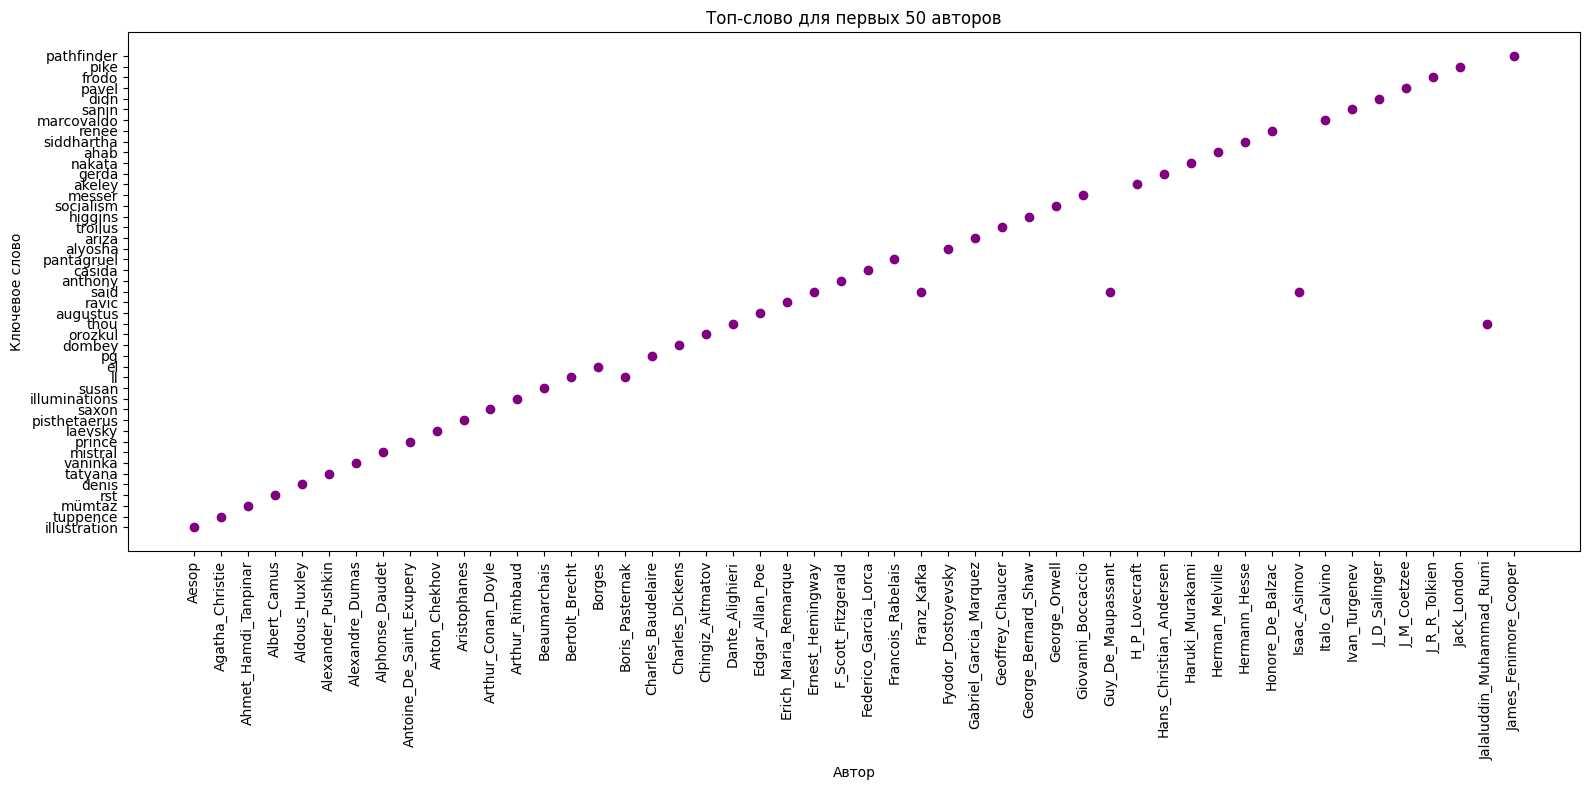

In [ ]:
top_word_per_author = b101.groupby('author')['tfidf_keywords'].first().reset_index()

top_word_per_author = top_word_per_author.head(50)

plt.figure(figsize=(16, 8))
plt.scatter(top_word_per_author['author'], top_word_per_author['tfidf_keywords'], color='purple')
plt.title('Топ-слово для первых 50 авторов')
plt.xlabel('Автор')
plt.ylabel('Ключевое слово')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Визуализация данных: облако наиболее частотных слов и биграмм для выявления ключевых тем (Word Clouds)

In [ ]:
all_text = ' '.join(b101['txt'].tolist()).lower()

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stopwords,
    max_words=100,
    colormap='viridis'
).generate(all_text)

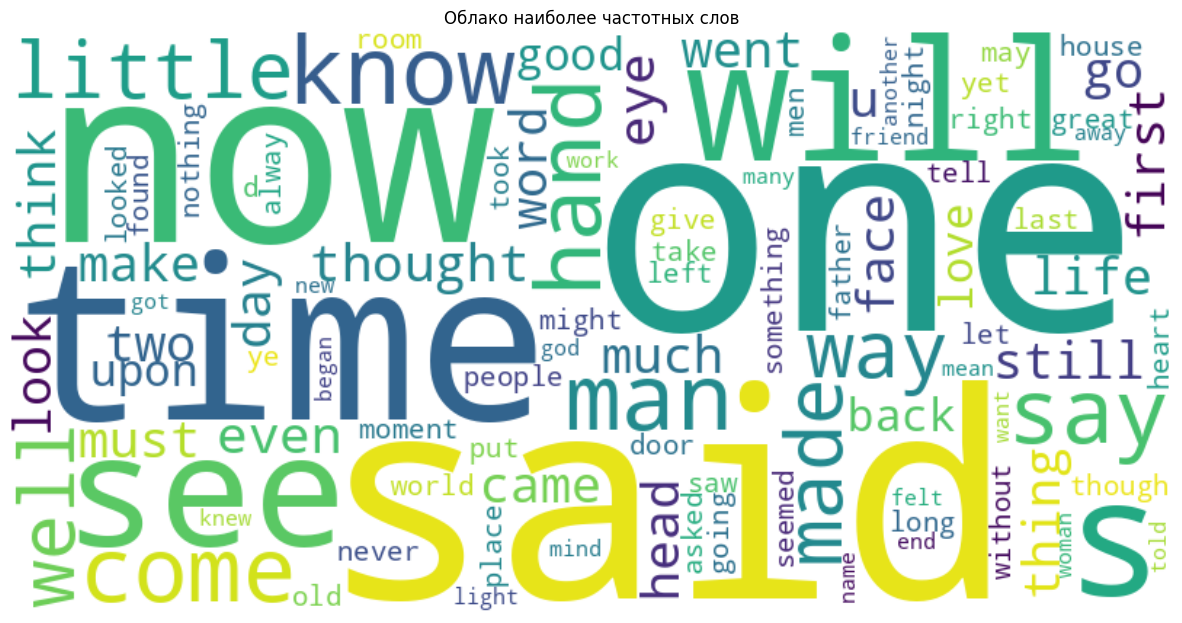

In [ ]:
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако наиболее частотных слов')
plt.show()

Рассчитаем словарный запас корпуса текстов

In [243]:
lex = len(set(all_text.split()))
lex

149146

In [250]:
b101['cnt_words_unique'] = b101['txt'].apply(lambda x: len(set(x.split())))

Средний словарный запас на автора

In [251]:
b101.cnt_words_unique.mean()

8152.554455445545

In [253]:
b101.to_parquet('//content//drive//MyDrive//books_//b101_2.pq', index = False)

Визуализация данных: методы снижения размерности (например, t-SNE) для визуализации текстовых представлений

In [ ]:
filtered_data = b101[:30]

tfidf = TfidfVectorizer(stop_words='english', max_features=500)
tfidf_matrix = tfidf.fit_transform(filtered_data['text'])

tsne_model = TSNE(n_components=2, random_state=42, perplexity=15, n_iter=1000)
tsne_results = tsne_model.fit_transform(tfidf_matrix.toarray())

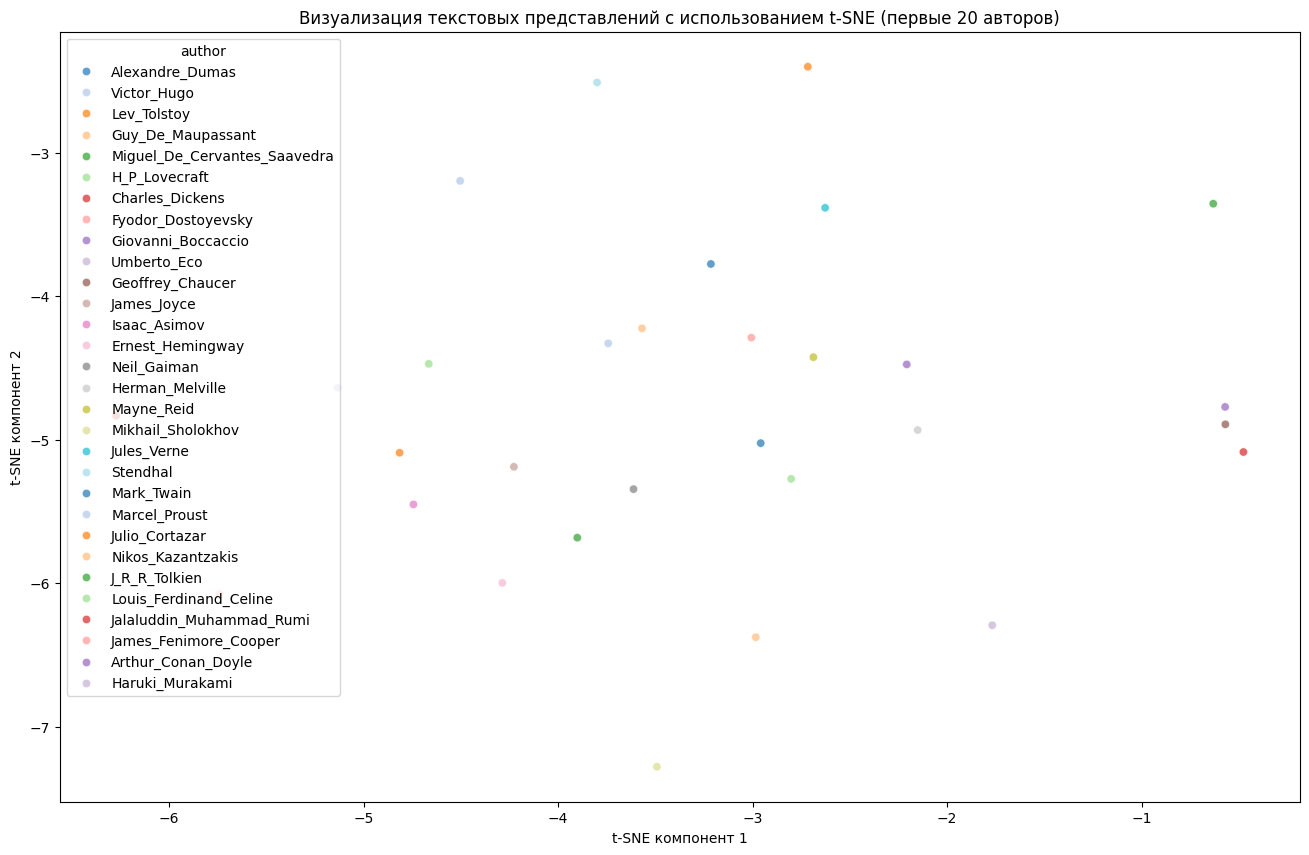

In [ ]:
filtered_data['tsne_1'] = tsne_results[:, 0]
filtered_data['tsne_2'] = tsne_results[:, 1]

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='author',
    palette='tab20',
    data=filtered_data,
    legend='full',
    alpha=0.7
)
plt.title('Визуализация текстовых представлений с использованием t-SNE (первые 20 авторов)')
plt.xlabel('t-SNE компонент 1')
plt.ylabel('t-SNE компонент 2')
plt.show()

Выполним векторизацию текстов, при помощи мешка слов

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer(lowercase=False, token_pattern=r'(?u)\b\w+\b')
X = cnt_vec.fit_transform(b101.txt)

In [ ]:
res = dict(sorted(cnt_vec.vocabulary_.items(), key=lambda item: item[1]))
pd.DataFrame(X.toarray(), columns=res.keys())

A  AAA  AAAgnes  AACR  AAs  ABAFT  ABANDON  ABBA  ABBAstyle  ABBOT  \
0     30    0        0     0    0      0        0     0          0      0   
1    228    0        0     0    0      0        0     0          0      0   
2     68    0        0     0    0      0        0     0          0      0   
3    111    0        0     0    0      0        0     0          0      0   
4     57    0        0     0    0      0        0     0          0      0   
..   ...  ...      ...   ...  ...    ...      ...   ...        ...    ...   
96    15    0        0     0    0      0        0     0          0      0   
97     3    0        0     0    0      0        0     0          0      0   
98    19    0        0     0    0      0        0     0          0      0   
99     4    0        0     0    0      0        0     0          0      0   
100   10    0        0     0    0      0        0     0          0      0   

     ...  Şakâyıkı  Şehzade  Şehzadebaşı  Şerefinize  Şânizâde  Şîr  şalvars  \
0    ...         0        0            0           0         0    0        0   
1    ...         0        0            0           0         0    0        0   
2    ...         0        0            0           0         0    0        0   
3    ...         0        0            0           0         0    0        0   
4    ...         0        0            0           0         0    0        0   
..   ...       ...      ...          ...         ...       ...  ...      ...   
96   ...         0        0            0           0         0    0        0   
97   ...         0        0            0           0         0    0        0   
98   ...         0        0            0           0         0    0        0   
99   ...         0        0            0           0         0    0        0   
100  ...         0        0            0           0         0    0        0   

     şerike  сovering  сzerov  
0         0         0       0  
1         0         0       0  
2         0         0       0  
3         0         0       0  
4         0         0       0  
..      ...       ...     ...  
96        0         0       0  
97        0         0       0  
98        0         0       0  
99        0         1       0  
100       0         0       0  

[101 rows x 145822 columns]

Выполним Tfidf векторизацию текстов

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(lowercase=False, token_pattern=r'(?u)\b\w+\b')
X = tfidf_vec.fit_transform(b101.txt)

In [ ]:
res = dict(sorted(cnt_vec.vocabulary_.items(), key=lambda item: item[1]))
pd.DataFrame(X.toarray(), columns=res.keys())

A  AAA  AAAgnes  AACR  AAs  ABAFT  ABANDON  ABBA  ABBAstyle  \
0    0.003019  0.0      0.0   0.0  0.0    0.0      0.0   0.0        0.0   
1    0.025950  0.0      0.0   0.0  0.0    0.0      0.0   0.0        0.0   
2    0.007764  0.0      0.0   0.0  0.0    0.0      0.0   0.0        0.0   
3    0.012956  0.0      0.0   0.0  0.0    0.0      0.0   0.0        0.0   
4    0.005984  0.0      0.0   0.0  0.0    0.0      0.0   0.0        0.0   
..        ...  ...      ...   ...  ...    ...      ...   ...        ...   
96   0.036339  0.0      0.0   0.0  0.0    0.0      0.0   0.0        0.0   
97   0.006136  0.0      0.0   0.0  0.0    0.0      0.0   0.0        0.0   
98   0.046362  0.0      0.0   0.0  0.0    0.0      0.0   0.0        0.0   
99   0.015948  0.0      0.0   0.0  0.0    0.0      0.0   0.0        0.0   
100  0.040881  0.0      0.0   0.0  0.0    0.0      0.0   0.0        0.0   

     ABBOT  ...  Şakâyıkı  Şehzade  Şehzadebaşı  Şerefinize  Şânizâde  Şîr  \
0      0.0  ...       0.0      0.0          0.0         0.0       0.0  0.0   
1      0.0  ...       0.0      0.0          0.0         0.0       0.0  0.0   
2      0.0  ...       0.0      0.0          0.0         0.0       0.0  0.0   
3      0.0  ...       0.0      0.0          0.0         0.0       0.0  0.0   
4      0.0  ...       0.0      0.0          0.0         0.0       0.0  0.0   
..     ...  ...       ...      ...          ...         ...       ...  ...   
96     0.0  ...       0.0      0.0          0.0         0.0       0.0  0.0   
97     0.0  ...       0.0      0.0          0.0         0.0       0.0  0.0   
98     0.0  ...       0.0      0.0          0.0         0.0       0.0  0.0   
99     0.0  ...       0.0      0.0          0.0         0.0       0.0  0.0   
100    0.0  ...       0.0      0.0          0.0         0.0       0.0  0.0   

     şalvars  şerike  сovering  сzerov  
0        0.0     0.0  0.000000     0.0  
1        0.0     0.0  0.000000     0.0  
2        0.0     0.0  0.000000     0.0  
3        0.0     0.0  0.000000     0.0  
4        0.0     0.0  0.000000     0.0  
..       ...     ...       ...     ...  
96       0.0     0.0  0.000000     0.0  
97       0.0     0.0  0.000000     0.0  
98       0.0     0.0  0.000000     0.0  
99       0.0     0.0  0.019663     0.0  
100      0.0     0.0  0.000000     0.0  

[101 rows x 145822 columns]